# Resnet 50, bez dropout

In [25]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda, GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint

Lokacija dataset-a

In [26]:
dataset_path = "../../data_set"

In [27]:
classes = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]


Inicijalizacija lista za cuvanje podataka


In [28]:
data = []
labels = []

Ucitavanje slika kroz klase


In [29]:
for class_name in classes:
    class_path = os.path.join(dataset_path, "Training", class_name)
    for filename in os.listdir(class_path):
        img_path = os.path.join(class_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Učitavanje slike u crno-belom formatu
        img = cv2.resize(img, (224, 224))  # Da sve slike budu 224x224px
        img = np.stack((img,)*3, axis=-1)  # tri kanala od grayscale slike (resnet-u treba 3 kanala)
        data.append(img)
        labels.append(classes.index(class_name))

Konvertovanje listi u numpy


In [30]:
data = np.array(data) / 255.0  # Normalizacija vrednosti piksela
labels = np.array(labels)

In [31]:
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)


ImageDataGenerator za data augmentation


In [32]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

ResNet-50 model

In [33]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers[-4:]:
    layer.trainable = True

Dodavanje prilagođenih slojeva

In [34]:
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(len(classes), activation='softmax')(x)


In [35]:
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Cuvanje tezina

In [36]:

checkpoint_path = "model.weights.h5" 
checkpoint = ModelCheckpoint(checkpoint_path, save_weights_only=True, save_best_only=True, monitor='val_loss', mode='min')


Treniranje modela

In [37]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=4), epochs=10, validation_data=(X_val, y_val), callbacks=[checkpoint])


Epoch 1/10


/home/teki/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


574/574 ━━━━━━━━━━━━━━━━━━━━ 905s 2s/step - accuracy: 0.3898 - loss: 1.3568 - val_accuracy: 0.3606 - val_loss: 1.4127
Epoch 2/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 865s 2s/step - accuracy: 0.3876 - loss: 1.2639 - val_accuracy: 0.4024 - val_loss: 1.7853
Epoch 3/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 868s 2s/step - accuracy: 0.4668 - loss: 1.1645 - val_accuracy: 0.2021 - val_loss: 1.9036
Epoch 4/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 870s 2s/step - accuracy: 0.4749 - loss: 1.1527 - val_accuracy: 0.4861 - val_loss: 1.2510
Epoch 5/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 874s 2s/step - accuracy: 0.5044 - loss: 1.1160 - val_accuracy: 0.4443 - val_loss: 1.5317
Epoch 6/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 876s 2s/step - accuracy: 0.5221 - loss: 1.0746 - val_accuracy: 0.3188 - val_loss: 1.5980
Epoch 7/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 877s 2s/step - accuracy: 0.5399 - loss: 1.0284 - val_accuracy: 0.1812 - val_loss: 4.5434
Epoch 8/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 880s 2s/step - accuracy: 0.5855 - loss: 0.9393 - val_accuracy: 0.155

In [38]:
model.load_weights(checkpoint_path)

Evaluacija modela na test skupu


In [39]:
test_data = []
test_labels = []

In [40]:
for class_name in classes:
    class_path = os.path.join(dataset_path, "Testing", class_name)
    for filename in os.listdir(class_path):
        img_path = os.path.join(class_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (224, 224))
        img = np.stack((img,)*3, axis=-1)
        test_data.append(img)
        test_labels.append(classes.index(class_name))

In [41]:
test_data = np.array(test_data) / 255.0
test_labels = np.array(test_labels)

Classification report

In [42]:
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)
report = classification_report(test_labels, predicted_classes, target_names=classes)
print("Classification report:")
print(report)

13/13 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step
Classification report:
                  precision    recall  f1-score   support

    glioma_tumor       0.45      0.29      0.35       100
meningioma_tumor       0.47      0.50      0.49       115
        no_tumor       0.38      0.55      0.45       105
 pituitary_tumor       0.46      0.34      0.39        74

        accuracy                           0.43       394
       macro avg       0.44      0.42      0.42       394
    weighted avg       0.44      0.43      0.43       394



Preciznost  je niska za sve klase, što znači da model često daje pogrešne pozitivne predikcije.

Odziv je umeren za meningioma tumore i slike bez tumora, ali nizak za glioma tumore i pituitary tumore, što znači da model propušta veliki broj stvarnih slučajeva ovih tumora.

F1-score vrednosti pokazuju da model ima osrednje performanse za sve klase, sa nešto boljim performansama za meningioma tumore.

Čuvanje rezultata


In [43]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)


2024-06-17 22:58:40.288384: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1382449152 exceeds 10% of free system memory.


In [44]:
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)


In [45]:
test_loss, test_accuracy = model.evaluate(test_data, test_labels, verbose=0)

In [46]:
results = {
    "Model": ["ResNet50 - Bez dropout"],
    "Train Loss": [train_loss],
    "Train Accuracy": [train_accuracy],
    "Validation Loss": [val_loss],
    "Validation Accuracy": [val_accuracy],
    "Test Loss": [test_loss],
    "Test Accuracy": [test_accuracy]
}

In [47]:
results_df = pd.DataFrame(results)
results_df.to_csv("model_results_resnet50_bez_dropout.csv", index=False)
print(results_df)

                    Model  Train Loss  Train Accuracy  Validation Loss  \
0  ResNet50 - Bez dropout    0.955658        0.577091         0.947498   

   Validation Accuracy  Test Loss  Test Accuracy  
0             0.571429   2.096019       0.431472  


Graficki prikaz rezultata

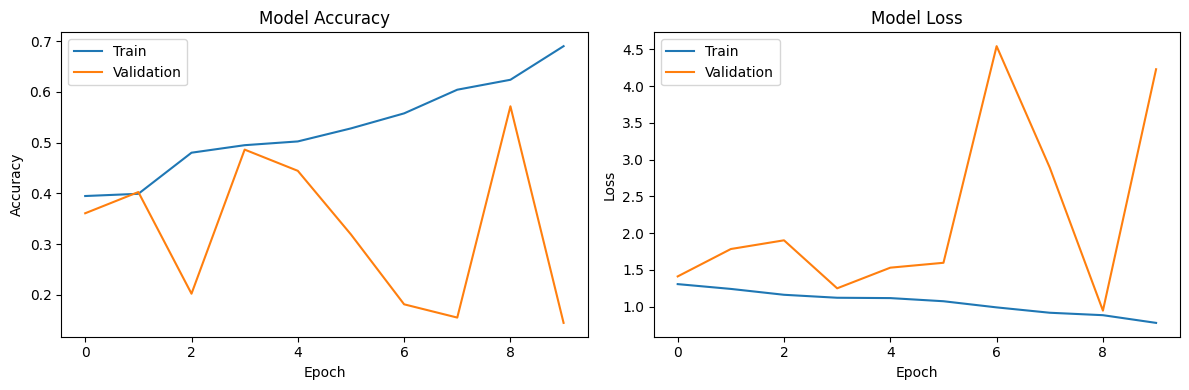

In [48]:
# train history
plt.figure(figsize=(12, 4))

# Plot training, validation
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training, validation
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

**Accuracy**

Tacnost na trening skupu raste do oko 0.7. Tacnost na validacionom skupu osciluje između 0.2 i 0.5, ukazujući na probleme sa generalizacijom.


**Loss**

Greska na trening setu opada ispod 1. Greska na validacionom skupu osciluje, ukazujući na nestabilnost i moguće preprilagodjavanje.